In [1]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.fftpack import fft
from dateutil.parser import parse

In [2]:
# ------------------------------
# Step 1: Fetch and Prepare Stock Data
# ------------------------------

# Set the date range
start_date = '2003-01-01'
end_date = '2021-12-31'

# Fetch data for Microsoft (MSFT)
msft = yf.Ticker('MSFT')
stock_data_msft = msft.history(start=start_date, end=end_date)

In [3]:
# Check if the stock data has multi-level columns
if isinstance(stock_data_msft.columns, pd.MultiIndex):
    print("Multi-level columns detected in stock data. Flattening columns...")
    stock_data_msft.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in stock_data_msft.columns]
else:
    print("Single-level columns detected in stock data.")

Single-level columns detected in stock data.


In [4]:
stock_data_msft.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-01-02 00:00:00-05:00,16.091720,16.537857,15.910188,16.528627,67025200,0.0,0.0
2003-01-03 00:00:00-05:00,16.488634,16.553247,16.270181,16.550171,55546800,0.0,0.0
2003-01-06 00:00:00-05:00,16.620931,16.993225,16.553241,16.851692,59456200,0.0,0.0
2003-01-07 00:00:00-05:00,16.897842,17.233215,16.824000,17.168602,80517400,0.0,0.0
2003-01-08 00:00:00-05:00,17.036300,17.091683,16.648623,16.688622,64566000,0.0,0.0


In [5]:
# Remove the timezone from the index
stock_data_msft.index = stock_data_msft.index.tz_localize(None)

In [6]:
# Reset index to make 'Date' a regular column
stock_data_msft.reset_index(inplace=True)

In [7]:
# Convert 'Date' column to datetime
stock_data_msft['Date'] = pd.to_datetime(stock_data_msft['Date'])

In [8]:
# ------------------------------
# Step 2: Load and Prepare News Data
# ------------------------------

# Load the cleaned business news data
news_data = pd.read_csv('cleaned_business_news_with_vader.csv')


In [9]:
news_data.head()

,publish_date,headline_text,compound_score,positive,neutral,negative
0,2003-02-19,businesses should prepare for terrorist attacks,-0.8225,0.000,0.345,0.655
1,2003-02-19,resource stocks boost all ords,0.4019,0.403,0.597,0.000
2,2003-02-19,shire offers assurances over finances,0.3400,0.375,0.625,0.000
3,2003-02-19,slow recovery predicted for aust economy,0.0000,0.000,1.000,0.000
4,2003-02-20,mud crab business on the move,0.0000,0.000,1.000,0.000


In [10]:
# Convert 'publish_date' to datetime
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], errors='coerce')

In [11]:
# Check for missing values
print(news_data.isnull().sum())

publish_date      0
headline_text     0
compound_score    0
positive          0
neutral           0
negative          0
dtype: int64


In [12]:
# ------------------------------
# Step 3: Merge Stock and News Data
# ------------------------------

# Merge stock data with news data on the Date and publish_date columns
merged_data_msft = pd.merge(stock_data_msft, news_data, left_on='Date', right_on='publish_date', how='inner')

In [13]:
merged_data_msft.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,publish_date,headline_text,compound_score,positive,neutral,negative
0,2003-02-19,15.322397,15.359437,14.921126,15.143369,46902700,0.08,0.0,2003-02-19,businesses should prepare for terrorist attacks,-0.8225,0.000,0.345,0.655
1,2003-02-19,15.322397,15.359437,14.921126,15.143369,46902700,0.08,0.0,2003-02-19,resource stocks boost all ords,0.4019,0.403,0.597,0.000
2,2003-02-19,15.322397,15.359437,14.921126,15.143369,46902700,0.08,0.0,2003-02-19,shire offers assurances over finances,0.3400,0.375,0.625,0.000
3,2003-02-19,15.322397,15.359437,14.921126,15.143369,46902700,0.08,0.0,2003-02-19,slow recovery predicted for aust economy,0.0000,0.000,1.000,0.000
4,2003-02-20,15.291529,15.353264,14.877911,14.902604,50897200,0.00,0.0,2003-02-20,mud crab business on the move,0.0000,0.000,1.000,0.000


In [14]:
# Fill missing sentiment scores with 0 (neutral)
merged_data_msft['compound_score'] = merged_data_msft['compound_score'].fillna(0)

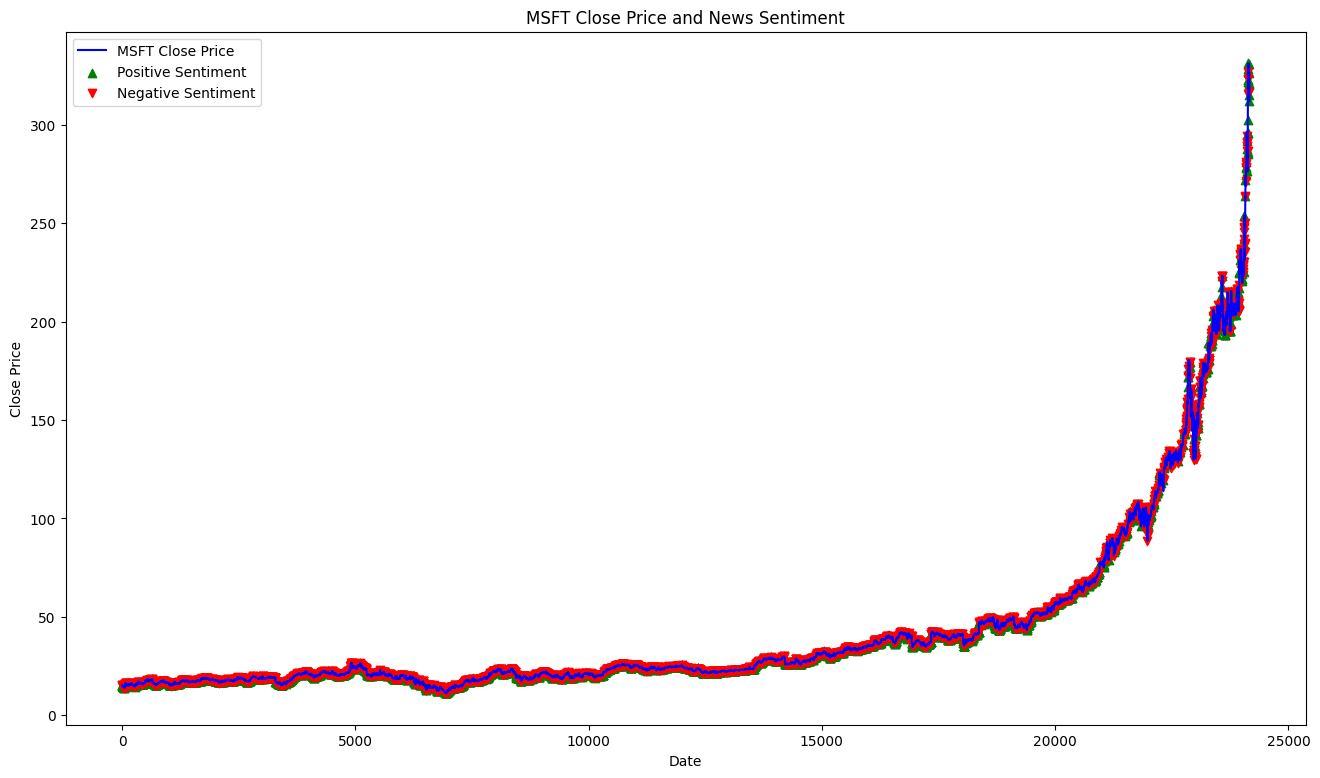

In [15]:
# ------------------------------
# Step 4: Visualize Data
# ------------------------------

plt.figure(figsize=(16, 9))
plt.plot(merged_data_msft['Close'], label='MSFT Close Price', color='blue')
plt.title('MSFT Close Price and News Sentiment')
plt.ylabel('Close Price')
plt.xlabel('Date')

# Highlight Positive Sentiment
plt.scatter(merged_data_msft.index[merged_data_msft['compound_score'] > 0], 
            merged_data_msft['Close'][merged_data_msft['compound_score'] > 0], 
            color='g', label='Positive Sentiment', marker='^')

# Highlight Negative Sentiment
plt.scatter(merged_data_msft.index[merged_data_msft['compound_score'] < 0], 
            merged_data_msft['Close'][merged_data_msft['compound_score'] < 0], 
            color='r', label='Negative Sentiment', marker='v')

plt.legend()
plt.show()

In [16]:
# ------------------------------
# Step 5: Perform Stationarity Tests
# ------------------------------

# Define a function for the ADF test
def adfuller_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Number of lags: {result[2]}")
    print(f"Number of observations: {result[3]}")
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (stationary)")
    else:
        print("Weak evidence against the null hypothesis (non-stationary)")

In [17]:
# Perform ADF test on raw closing prices
adfuller_test(merged_data_msft['Close'])

ADF Test Statistic: 8.75652906317626
p-value: 1.0
Number of lags: 48
Number of observations: 24114
Weak evidence against the null hypothesis (non-stationary)


In [18]:
# Log-transform the closing prices
merged_data_msft['log_close'] = np.log(merged_data_msft['Close'])

# Differencing to achieve stationarity
merged_data_msft['log_diff'] = merged_data_msft['log_close'].diff()

In [19]:
# Perform ADF test on differenced data
adfuller_test(merged_data_msft['log_diff'])

ADF Test Statistic: -25.94846806670987
p-value: 0.0
Number of lags: 41
Number of observations: 24120
Strong evidence against the null hypothesis (stationary)


In [21]:
# ------------------------------
# Step 7: Split Data into Training and Test Sets
# ------------------------------

# Split the data (80% training, 20% testing)
train_size = int(len(merged_data_msft) * 0.8)
train_data = merged_data_msft[:train_size]
test_data = merged_data_msft[train_size:]

# Prepare training and testing datasets for SARIMAX
train_prices = train_data[['log_diff']]
train_sentiment = train_data[['compound_score']]
test_prices = test_data[['log_diff']]
test_sentiment = test_data[['compound_score']]

In [22]:
# ------------------------------
# Step 8: Ensure Alignment of train_prices and train_sentiment
# ------------------------------

# Reset the indices of both train_prices and train_sentiment to ensure they align
train_prices = train_prices.reset_index(drop=True)
train_sentiment = train_sentiment.reset_index(drop=True)

# Verifying the alignment of the indices
print("Train Prices Length:", len(train_prices))
print("Train Sentiment Length:", len(train_sentiment))
print("Indices Aligned:", train_prices.index.equals(train_sentiment.index))

Train Prices Length: 19330
Train Sentiment Length: 19330
Indices Aligned: True


In [23]:
# ------------------------------
# Step 9: Build and Train SARIMAX Model
# ------------------------------

# Build and train SARIMAX model with train_prices as endogenous and train_sentiment as exogenous
sarimax_model = SARIMAX(
    train_prices,  # Endogenous variable (target variable)
    exog=train_sentiment,  # Exogenous variable (predictor)
    order=(1, 0, 1),  # ARMA(1, 1) order
    enforce_stationarity=False,  # Allow non-stationarity
    enforce_invertibility=False  # Allow non-invertibility
)

In [24]:
# Fitting the model
sarimax_results = sarimax_model.fit(disp=False)

In [25]:
# Output the model summary
print(sarimax_results.summary())

                               SARIMAX Results                                
Dep. Variable:               log_diff   No. Observations:                19330
Model:               SARIMAX(1, 0, 1)   Log Likelihood               68560.944
Date:                Wed, 27 Nov 2024   AIC                        -137113.889
Time:                        14:03:26   BIC                        -137082.412
Sample:                             0   HQIC                       -137103.573
                              - 19330                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
compound_score   -8.8e-05      0.000     -0.529      0.597      -0.000       0.000
ar.L1             -0.5893      0.007    -85.757      0.000      -0.603      -0.576
ma.L1              1.7029      0.002

In [26]:
# ------------------------------
# Step 10: Forecasting
# ------------------------------

# Forecast on the test set (using the same length as the test data)
forecast = sarimax_results.get_forecast(steps=len(test_prices), exog=test_sentiment)
forecast_mean = forecast.predicted_mean

In [27]:
# Convert predictions back to the original scale by reversing the log transformation and adding the cumulative sum
forecast_cumsum = forecast_mean.cumsum() + train_prices['log_diff'].iloc[-1]
forecast_prices = np.exp(forecast_cumsum)

In [28]:
# Convert test prices back to the original scale (actual prices)
actual_prices = np.exp(test_prices['log_diff'])

In [29]:
# ------------------------------
# Step 11: Model Evaluation
# ------------------------------

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, forecast_prices)
mae = mean_absolute_error(actual_prices, forecast_prices)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 8.797838690126143e-05
Mean Absolute Error (MAE): 0.004604581700908485


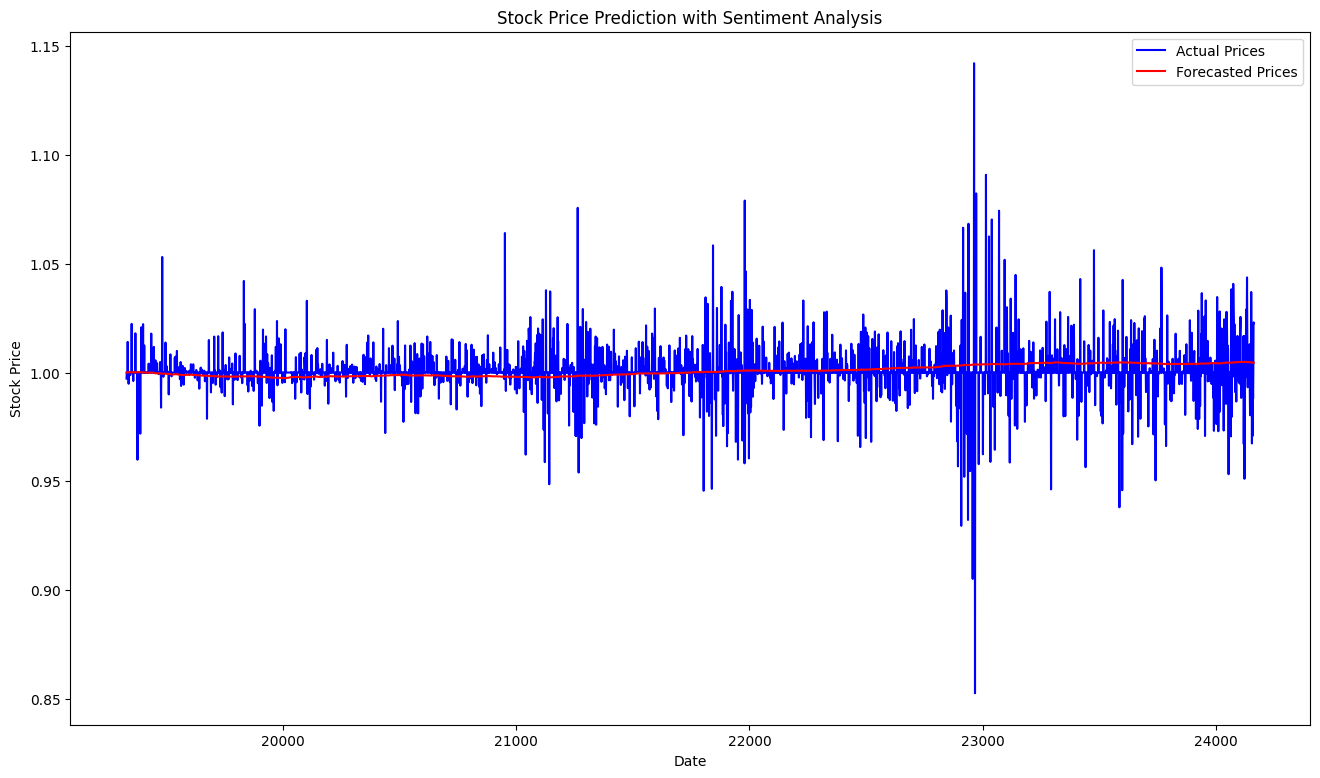

In [30]:
# ------------------------------
# Step 12: Visualization
# ------------------------------

# Plot Actual vs Predicted Prices
plt.figure(figsize=(16, 9))
plt.plot(actual_prices, label="Actual Prices", color="blue")
plt.plot(forecast_prices, label="Forecasted Prices", color="red")
plt.title("Stock Price Prediction with Sentiment Analysis")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

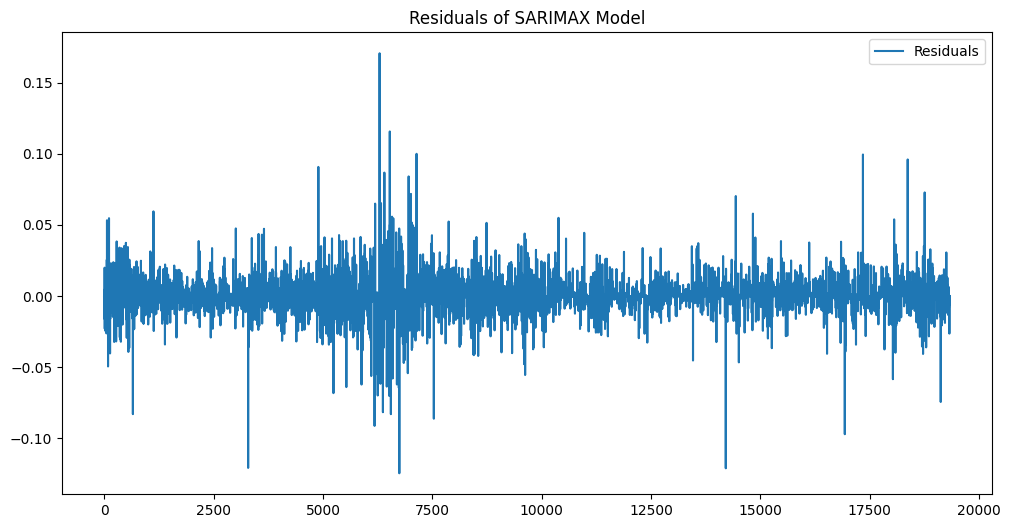

In [31]:
# Residual Analysis
residuals = sarimax_results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals")
plt.title("Residuals of SARIMAX Model")
plt.legend()
plt.show()

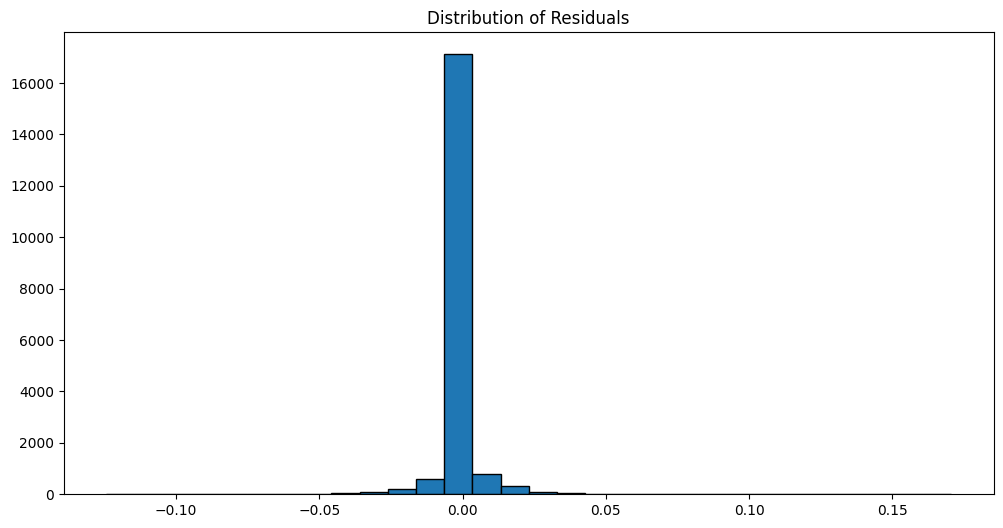

In [32]:
# Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Distribution of Residuals")
plt.show()